# Health Metrics in Women's Rugby 7s

### Daniel Connolly and Bryce Mann

Data Science Spring 2019

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

Here, we explore the women's rugby 7s data as part of the nationwide datafest challenge. We explore the way the events of one day might affect performance, or at least perceived performance, the next day and how hits/tackles affect perceived health, among other things. We find some evidence of DOMS but little predictive power in the wellness data of game outcomes and scoring.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

# from utils import decorate
from thinkstats2 import Pmf, Cdf

import thinkstats2
import thinkplot
from datetime import datetime
import time
import math
import statsmodels.formula.api as smf

In [2]:
games = pd.read_csv('games.csv')
gps = pd.read_csv('gps.csv')
rpe = pd.read_csv('rpe.csv')
wellness = pd.read_csv('wellness.csv')

In [3]:
games.replace('W',1,inplace=True)
games.replace('L',0,inplace=True)

We looked into the team's win percentage, points scored, and points allowed at various tournaments throughout the season. This was just to familiarize ourselves with the data.

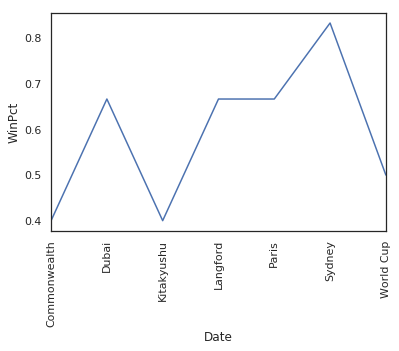

In [4]:
grouped1 = games.groupby('Tournament')
series = grouped1['Outcome'].mean()
series.plot()
plt.xlabel('Date')
plt.ylabel('WinPct')
plt.xticks(rotation=90)
plt.show()

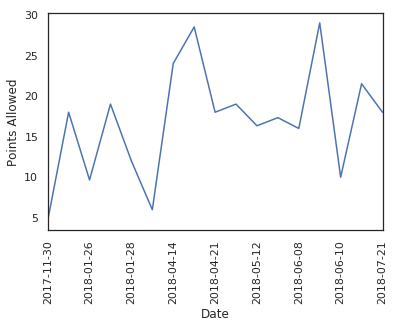

In [5]:
grouped1 = games.groupby('Date')
series = grouped1['TeamPointsAllowed'].mean()
series.plot()
plt.xlabel('Date')
plt.ylabel('Points Allowed')
plt.xticks(rotation=90)
plt.show()

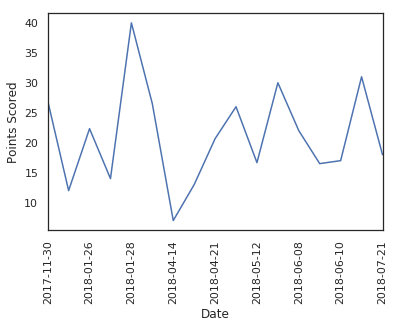

In [6]:
grouped1 = games.groupby('Date')
series = grouped1['TeamPoints'].mean()
series.plot()
plt.xlabel('Date')
plt.ylabel('Points Scored')
plt.xticks(rotation=90)
plt.show()

**Replacing dates with increasing integers to better compare things happening on the certain days**

In [7]:
for i, row in rpe.iterrows():
    t = datetime.strptime(row['Date'], '%Y-%m-%d')
    a1 = int(t.strftime('%Y%m%d'))
    rpe.at[i,'Date'] = a1

for i, row in games.iterrows():
    t = datetime.strptime(row['Date'], '%Y-%m-%d')
    a1 = int(t.strftime('%Y%m%d'))
    games.at[i,'Date'] = a1

for i, row in wellness.iterrows():
    t = datetime.strptime(row['Date'], '%Y-%m-%d')
    a1 = int(t.strftime('%Y%m%d'))
    wellness.at[i,'Date'] = a1
    
    #replacing percent strings with float percents
    wellness.at[i,'TrainingReadiness'] = float(row['TrainingReadiness'].strip('%'))

In [8]:
games.head()

,GameID,Date,Tournament,TournamentGame,Team,Opponent,Outcome,TeamPoints,TeamPointsAllowed
0,1,20171130,Dubai,1,Canada,Spain,1,19,0
1,2,20171130,Dubai,2,Canada,Ireland,1,31,0
2,3,20171130,Dubai,3,Canada,Fiji,1,31,14
3,4,20171201,Dubai,4,Canada,France,1,24,19
4,5,20171201,Dubai,5,Canada,Australia,0,7,25


In [9]:
rpe.head()

,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself
0,20180721,13,Yes,Mobility/Recovery,5.0,0.0,0.0,446.0,323.1,303.25,1.07,NaN,NaN,Not at all
1,20180721,13,Yes,Game,29.0,7.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all
2,20180721,13,Yes,Game,27.0,9.0,243.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all
3,20180720,11,Yes,Game,36.0,6.0,216.0,534.0,256.3,344.18,0.74,9.0,10.0,Absolutely
4,20180720,11,Yes,Game,36.0,8.0,288.0,NaN,NaN,NaN,NaN,9.0,10.0,Absolutely


In [10]:
wellness.head()

,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,BedTime,WakeTime,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,20180721,1,3,3,2,3,23:00:00,07:00:00,8.00,2,13,No,No,Yes,Excellent,Yes,No,NaN,0
1,20180721,2,4,3,4,4,23:00:00,07:00:00,8.00,4,19,Yes,No,Yes,NaN,NaN,Yes,1.010,0
2,20180721,3,3,3,5,4,22:30:00,06:30:00,8.00,4,19,No,No,No,NaN,NaN,Yes,1.016,100
3,20180721,4,2,3,5,4,00:30:00,07:00:00,6.50,1,15,No,No,Yes,Excellent,Yes,Yes,1.025,95
4,20180721,5,5,3,4,4,23:45:00,07:00:00,7.25,4,20,No,No,No,Okay,Yes,Yes,1.022,100


**Standardizing self reported player answers by calculating the z score for each players answers**

In [11]:
def standardize_col(df, col):
    
    player_grouped = df.groupby('PlayerID')
    
    for p_id in list(range(1,18)):
        mean = player_grouped.get_group(p_id)[col].mean()
        std = player_grouped.get_group(p_id)[col].std()
        for i, row in df.iterrows():
            if row['PlayerID'] == p_id:
                df.at[i, col+'_Z'] = (row[col]-mean)/std
            else:
                pass

wellness_cols = ['Fatigue', 'Soreness', 'Irritability', 'Desire', 'SleepQuality', 'TrainingReadiness']

for col in wellness_cols:
    standardize_col(wellness, col)

standardize_col(rpe,'RPE')

In [12]:
rpe.head()

,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself,RPE_Z
0,20180721,13,Yes,Mobility/Recovery,5.0,0.0,0.0,446.0,323.1,303.25,1.07,NaN,NaN,Not at all,-1.253472
1,20180721,13,Yes,Game,29.0,7.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,1.153176
2,20180721,13,Yes,Game,27.0,9.0,243.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,1.840789
3,20180720,11,Yes,Game,36.0,6.0,216.0,534.0,256.3,344.18,0.74,9.0,10.0,Absolutely,0.750374
4,20180720,11,Yes,Game,36.0,8.0,288.0,NaN,NaN,NaN,NaN,9.0,10.0,Absolutely,1.695403


In [13]:
wellness.head()

,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,BedTime,WakeTime,SleepHours,SleepQuality,...,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness,Fatigue_Z,Soreness_Z,Irritability_Z,Desire_Z,SleepQuality_Z,TrainingReadiness_Z
0,20180721,1,3,3,2,3,23:00:00,07:00:00,8.00,2,...,Yes,No,NaN,0,0.318219,-0.304322,-0.987002,-0.415362,-1.551148,-0.562599
1,20180721,2,4,3,4,4,23:00:00,07:00:00,8.00,4,...,NaN,Yes,1.010,0,0.207884,-0.230312,-0.186841,-0.121453,-0.100390,-0.410237
2,20180721,3,3,3,5,4,22:30:00,06:30:00,8.00,4,...,NaN,Yes,1.016,100,-0.578512,-0.279482,0.143069,2.144929,0.255789,0.558418
3,20180721,4,2,3,5,4,00:30:00,07:00:00,6.50,1,...,Yes,Yes,1.025,95,-1.591780,-0.605094,0.463336,1.575278,-1.447874,0.621488
4,20180721,5,5,3,4,4,23:45:00,07:00:00,7.25,4,...,Yes,Yes,1.022,100,1.808898,-0.983282,0.054038,-0.403411,0.286967,0.891845


This exploration was using multiple regression to see if the players self reported wellness scores on game days could be used to predict whether they would win, how many points they would score, and how many points they gave up. To do this we calculated the mean wellness scores on game day dates and added them to the game dataframe in order to use the statsmodels module to run multiple regression. The cell below adds these values to the game dataframe.

In [14]:
date_grouped = wellness.groupby('Date')
mean_fat = date_grouped['Fatigue_Z'].mean()
mean_sore = date_grouped['Soreness_Z'].mean()
mean_des = date_grouped['Desire_Z'].mean()
mean_irr = date_grouped['Irritability_Z'].mean()
mean_sleepq = date_grouped['SleepQuality_Z'].mean()
mean_sleept = date_grouped['SleepHours'].mean()
mean_readiness = date_grouped['TrainingReadiness_Z'].mean()

for i, row in games.iterrows():
    games.at[i, 'Fat'] = mean_fat[row['Date']]
    games.at[i, 'Sore'] = mean_sore[row['Date']]
    games.at[i, 'Des'] = mean_des[row['Date']]
    games.at[i, 'Irr'] = mean_irr[row['Date']]
    games.at[i, 'SleepQ'] = mean_sleepq[row['Date']]
    games.at[i, 'SleepT'] = mean_sleept[row['Date']]
    games.at[i, 'Readiness'] = mean_readiness[row['Date']]
    
games.head()

,GameID,Date,Tournament,TournamentGame,Team,Opponent,Outcome,TeamPoints,TeamPointsAllowed,Fat,Sore,Des,Irr,SleepQ,SleepT,Readiness
0,1,20171130,Dubai,1,Canada,Spain,1,19,0,0.494438,0.974050,1.672751,0.383781,0.079810,8.203125,0.619255
1,2,20171130,Dubai,2,Canada,Ireland,1,31,0,0.494438,0.974050,1.672751,0.383781,0.079810,8.203125,0.619255
2,3,20171130,Dubai,3,Canada,Fiji,1,31,14,0.494438,0.974050,1.672751,0.383781,0.079810,8.203125,0.619255
3,4,20171201,Dubai,4,Canada,France,1,24,19,-0.352514,-1.085568,1.077209,0.132107,-0.475545,7.171875,0.524882
4,5,20171201,Dubai,5,Canada,Australia,0,7,25,-0.352514,-1.085568,1.077209,0.132107,-0.475545,7.171875,0.524882


In [15]:
well2 = wellness.copy()

We combined some data from the games dataframe with the gps so that we would know the dates on which certain games happened.

In [16]:
game2 = games[['GameID', 'Date']].copy()
gps = pd.merge(game2,gps, on=['GameID'])

We started by making a preliminary correlation matrix to see if anything jumped out as a good predictor of game outcome or point totals.

In [17]:
columns = ['Outcome', 'TeamPoints', 'TeamPointsAllowed', 'Fat', 'Sore', 'Des', 'Irr', 'SleepQ', 'SleepT',
           'Sum_Z']
games['Sum_Z'] = games['Fat']+games['Sore']+games['Des']+games['Irr']+games['SleepQ']+games['Readiness']
games[columns].corr()

,Outcome,TeamPoints,TeamPointsAllowed,Fat,Sore,Des,Irr,SleepQ,SleepT,Sum_Z
Outcome,1.000000,0.740171,-0.751528,0.188176,0.216107,0.153654,0.042370,0.081989,0.125938,0.177702
TeamPoints,0.740171,1.000000,-0.483780,0.185534,0.220732,0.120468,0.100627,0.006960,0.182159,0.147918
TeamPointsAllowed,-0.751528,-0.483780,1.000000,-0.308816,-0.304649,-0.216315,-0.129036,-0.187217,-0.078184,-0.287469
Fat,0.188176,0.185534,-0.308816,1.000000,0.884424,0.535827,0.595916,0.854533,0.554684,0.909093
Sore,0.216107,0.220732,-0.304649,0.884424,1.000000,0.594816,0.446359,0.734270,0.629811,0.911977
Des,0.153654,0.120468,-0.216315,0.535827,0.594816,1.000000,0.752196,0.695644,-0.025541,0.800593
Irr,0.042370,0.100627,-0.129036,0.595916,0.446359,0.752196,1.000000,0.817361,0.137786,0.733905
SleepQ,0.081989,0.006960,-0.187217,0.854533,0.734270,0.695644,0.817361,1.000000,0.387897,0.915718
SleepT,0.125938,0.182159,-0.078184,0.554684,0.629811,-0.025541,0.137786,0.387897,1.000000,0.458045
Sum_Z,0.177702,0.147918,-0.287469,0.909093,0.911977,0.800593,0.733905,0.915718,0.458045,1.000000


These wellness scored don't seem to be a particularly good predictor of winning or losing, as there is a pretty low r^2 value.

In [18]:
outcome_model = smf.logit('Outcome ~ Fat + Sore + Des + Irr + SleepQ + SleepT + Readiness', data=games)
outcome_res = outcome_model.fit()
outcome_res.summary()

Optimization terminated successfully.
         Current function value: 0.616572
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                   38
Model:                          Logit   Df Residuals:                       30
Method:                           MLE   Df Model:                            7
Date:                Fri, 12 Apr 2019   Pseudo R-squ.:                 0.08087
Time:                        00:49:41   Log-Likelihood:                -23.430
converged:                       True   LL-Null:                       -25.491
                                        LLR p-value:                    0.7655
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.4819     13.894     -0.898      0.369     -39.713      14.749
Fat            2.3093      2.565      0.900      0.368      -2.718       7.337
Sore          -1.0263      1.813     -0.566      0.571      -4.581       2.528
Des            3.6516      3.255      1.122      0.262      -2.728      10.032
Irr           -3.1695      5.056     -0.627      0.531     -13.079       6.740
SleepQ        -2.1108      3.189     -0.662      0.508      -8.360       4.139
SleepT         1.1104      1.432      0.776      0.438      -1.696       3.916
Readiness     -1.3527      2.819     -0.480      0.631      -6.877       4.171
==============================================================================
"""

This is the best multiple regression model we found so far, using the wellness scores to try to predict the points that the team scored in a game. The r^2 value is still pretty low, but its at least better.

In [19]:
offense_model = smf.ols('TeamPoints ~ Fat + Sore + Des + Irr + SleepQ + SleepT + Readiness', data=games)
offense_res = offense_model.fit()
offense_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             TeamPoints   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     1.597
Date:                Fri, 12 Apr 2019   Prob (F-statistic):              0.175
Time:                        00:49:41   Log-Likelihood:                -136.94
No. Observations:                  38   AIC:                             289.9
Df Residuals:                      30   BIC:                             303.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -48.6181     64.772     -0.751      0.459    -180.900      83.664
Fat           10.9513     11.650      0.940      0.355     -12.841      34.743
Sore          -0.3869      8.225     -0.047      0.963     -17.185      16.412
Des           12.6822     14.253      0.890      0.381     -16.427      41.791
Irr           16.6055     21.719      0.765      0.450     -27.750      60.961
SleepQ       -31.1177     14.480     -2.149      0.040     -60.691      -1.545
SleepT         5.8181      6.759      0.861      0.396      -7.985      19.621
Readiness    -13.3669     12.958     -1.032      0.311     -39.831      13.097
==============================================================================
Omnibus:                        1.149   Durbin-Watson:                   2.362
Prob(Omnibus):                  0.563   Jarque-Bera (JB):                0.922
Skew:                           0.074   Prob(JB):                        0.631
Kurtosis:                       2.252   Cond. No.                         352.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Looking at points allowed, still pretty low predictive quality.

In [20]:
defense_model = smf.ols('TeamPointsAllowed ~ Fat + Sore + Des + Irr + SleepQ + SleepT + Readiness', data=games)
defense_res = defense_model.fit()
defense_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      TeamPointsAllowed   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.8461
Date:                Fri, 12 Apr 2019   Prob (F-statistic):              0.559
Time:                        00:49:41   Log-Likelihood:                -133.22
No. Observations:                  38   AIC:                             282.4
Df Residuals:                      30   BIC:                             295.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.7724     58.733     -0.217      0.829    -132.722     107.177
Fat          -11.9329     10.564     -1.130      0.268     -33.507       9.641
Sore          -3.1246      7.459     -0.419      0.678     -18.357      12.108
Des            2.2362     12.924      0.173      0.864     -24.159      28.631
Irr           -7.0840     19.694     -0.360      0.722     -47.304      33.136
SleepQ        14.5318     13.130      1.107      0.277     -12.284      41.348
SleepT         4.4085      6.129      0.719      0.478      -8.108      16.925
Readiness     -7.3942     11.750     -0.629      0.534     -31.391      16.603
==============================================================================
Omnibus:                        1.947   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.378   Jarque-Bera (JB):                1.243
Skew:                          -0.130   Prob(JB):                        0.537
Kurtosis:                       2.153   Cond. No.                         352.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**The next exploration we did was using the RPE (rate of percieved exertion values reported for training sessions) values of each day to predict wellness scores for the next day. In order to do this our first step was to add the wellness z scores of the next day to the rpe dataframe.**

In [21]:
rpe.head()

,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself,RPE_Z
0,20180721,13,Yes,Mobility/Recovery,5.0,0.0,0.0,446.0,323.1,303.25,1.07,NaN,NaN,Not at all,-1.253472
1,20180721,13,Yes,Game,29.0,7.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,1.153176
2,20180721,13,Yes,Game,27.0,9.0,243.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,1.840789
3,20180720,11,Yes,Game,36.0,6.0,216.0,534.0,256.3,344.18,0.74,9.0,10.0,Absolutely,0.750374
4,20180720,11,Yes,Game,36.0,8.0,288.0,NaN,NaN,NaN,NaN,9.0,10.0,Absolutely,1.695403


In [22]:
wellness.head()

,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,BedTime,WakeTime,SleepHours,SleepQuality,...,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness,Fatigue_Z,Soreness_Z,Irritability_Z,Desire_Z,SleepQuality_Z,TrainingReadiness_Z
0,20180721,1,3,3,2,3,23:00:00,07:00:00,8.00,2,...,Yes,No,NaN,0,0.318219,-0.304322,-0.987002,-0.415362,-1.551148,-0.562599
1,20180721,2,4,3,4,4,23:00:00,07:00:00,8.00,4,...,NaN,Yes,1.010,0,0.207884,-0.230312,-0.186841,-0.121453,-0.100390,-0.410237
2,20180721,3,3,3,5,4,22:30:00,06:30:00,8.00,4,...,NaN,Yes,1.016,100,-0.578512,-0.279482,0.143069,2.144929,0.255789,0.558418
3,20180721,4,2,3,5,4,00:30:00,07:00:00,6.50,1,...,Yes,Yes,1.025,95,-1.591780,-0.605094,0.463336,1.575278,-1.447874,0.621488
4,20180721,5,5,3,4,4,23:45:00,07:00:00,7.25,4,...,Yes,Yes,1.022,100,1.808898,-0.983282,0.054038,-0.403411,0.286967,0.891845


putting wellness avg data in the rpe dataframe, where the wellness data is from the day after the rpe data

These next 2 cells take the rpe dataframe and add the wellness z scores from the following day to it so that we can run statsmodels regression on it.

In [23]:
def next_day(rpe_df, wellness_df, rpe_row):
    
    rpe_date = rpe_row['Date']
    next_date = wellness_df[wellness_df['Date'] > rpe_date].min()
    
    return next_date['Date']

In [24]:
well_dates = wellness.groupby('Date')
columns = ['Fatigue_Z', 'Soreness_Z', 'Desire_Z', 'Irritability_Z',
           'SleepQuality_Z']

for i, row in rpe.iterrows():
    if row['Date'] < rpe['Date'].max():
        well_date = next_day(rpe, wellness, row)
        well_rows = well_dates.get_group(well_date)
        for i2, row2 in well_rows.iterrows():
            pid = row2['PlayerID']
            if row['PlayerID'] == pid:
                for col in columns:
                    rpe.at[i, col] = row2[col]

rpe.head()

,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself,RPE_Z,Fatigue_Z,Soreness_Z,Desire_Z,Irritability_Z,SleepQuality_Z
0,20180721,13,Yes,Mobility/Recovery,5.0,0.0,0.0,446.0,323.1,303.25,1.07,NaN,NaN,Not at all,-1.253472,NaN,NaN,NaN,NaN,NaN
1,20180721,13,Yes,Game,29.0,7.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,1.153176,NaN,NaN,NaN,NaN,NaN
2,20180721,13,Yes,Game,27.0,9.0,243.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,1.840789,NaN,NaN,NaN,NaN,NaN
3,20180720,11,Yes,Game,36.0,6.0,216.0,534.0,256.3,344.18,0.74,9.0,10.0,Absolutely,0.750374,1.671003,0.426559,2.815371,0.652563,-0.230249
4,20180720,11,Yes,Game,36.0,8.0,288.0,NaN,NaN,NaN,NaN,9.0,10.0,Absolutely,1.695403,1.671003,0.426559,2.815371,0.652563,-0.230249


Now, we add several columns to our copy of the wellness dataframe containing wellness data from the following three days.

In [25]:
well_dates = well2.groupby('Date')
columns = ['Fatigue_Z', 'Soreness_Z', 'Desire_Z', 'Irritability_Z',
           'SleepQuality_Z', 'USG']

for i, row in well2.iterrows():
    if row['Date'] < well2['Date'].max():
        date = row['Date']
        next_date = well2[well2['Date'] > date]['Date'].min()
        two_days = well2[well2['Date'] > next_date]['Date'].min()
        three_days = well2[well2['Date'] > two_days]['Date'].min()
        well_rows_next = well_dates.get_group(next_date)
        for i2, row2 in well_rows_next.iterrows():
            pid = row2['PlayerID']
            if row['PlayerID'] == pid:
                for col in columns:
                    well2.at[i, col + '_next'] = row2[col]
        if (not math.isnan(two_days)):
            well_rows_two = well_dates.get_group(two_days)
            for i3, row3 in well_rows_two.iterrows():
                pid = row3['PlayerID']
                if row['PlayerID'] == pid:
                    for col in columns:
                        well2.at[i, col + '_twodays'] = row3[col]
        if (not math.isnan(three_days)):
            well_rows_three = well_dates.get_group(three_days)
            for i4, row4 in well_rows_three.iterrows():
                pid = row4['PlayerID']
                if row['PlayerID'] == pid:
                    for col in columns:
                        well2.at[i, col + '_threedays'] = row4[col]

In [26]:
rpe.head(20)

,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself,RPE_Z,Fatigue_Z,Soreness_Z,Desire_Z,Irritability_Z,SleepQuality_Z
0,20180721,13,Yes,Mobility/Recovery,5.0,0.0,0.0,446.0,323.1,303.25,1.07,NaN,NaN,Not at all,-1.253472,NaN,NaN,NaN,NaN,NaN
1,20180721,13,Yes,Game,29.0,7.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,1.153176,NaN,NaN,NaN,NaN,NaN
2,20180721,13,Yes,Game,27.0,9.0,243.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,1.840789,NaN,NaN,NaN,NaN,NaN
3,20180720,11,Yes,Game,36.0,6.0,216.0,534.0,256.3,344.18,0.74,9.0,10.0,Absolutely,0.750374,1.671003,0.426559,2.815371,0.652563,-0.230249
4,20180720,11,Yes,Game,36.0,8.0,288.0,NaN,NaN,NaN,NaN,9.0,10.0,Absolutely,1.695403,1.671003,0.426559,2.815371,0.652563,-0.230249
5,20180720,11,Yes,Mobility/Recovery,15.0,2.0,30.0,NaN,NaN,NaN,NaN,9.0,10.0,Absolutely,-1.139683,1.671003,0.426559,2.815371,0.652563,-0.230249
6,20180720,13,Yes,Game,27.0,6.0,162.0,306.0,259.4,287.32,0.90,NaN,NaN,Not at all,0.809369,0.802189,0.110634,2.273088,0.000000,0.204348
7,20180720,13,Yes,Game,24.0,6.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,0.809369,0.802189,0.110634,2.273088,0.000000,0.204348
8,20180720,13,Yes,Mobility/Recovery,10.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,-1.253472,0.802189,0.110634,2.273088,0.000000,0.204348
9,20180719,1,Yes,Skills,60.0,3.0,180.0,180.0,87.9,140.54,0.63,NaN,NaN,NaN,-0.254554,0.318219,0.700575,0.450886,0.066465,-1.551148


Initial correlation matrix. Soreness is the most correlated with RPE, but still not very high.

In [27]:
columns = ['RPE_Z', 'Fatigue_Z', 'Soreness_Z', 'Desire_Z', 'Irritability_Z',
           'SleepQuality_Z']
rpe[columns].corr()

,RPE_Z,Fatigue_Z,Soreness_Z,Desire_Z,Irritability_Z,SleepQuality_Z
RPE_Z,1.000000,-0.088729,-0.214393,-0.059556,-0.015304,-0.008024
Fatigue_Z,-0.088729,1.000000,0.442297,0.446630,0.300802,0.383698
Soreness_Z,-0.214393,0.442297,1.000000,0.348918,0.179070,0.152310
Desire_Z,-0.059556,0.446630,0.348918,1.000000,0.360820,0.218769
Irritability_Z,-0.015304,0.300802,0.179070,0.360820,1.000000,0.261351
SleepQuality_Z,-0.008024,0.383698,0.152310,0.218769,0.261351,1.000000


**These next cells plot the wellness scores as dependent variables against the (hopefully predictive) RPEs of the previous. Unfortunately nothing seems to be even remotely predictive. We are not done with this path though, as we are exploring ways to combine rpe values from the same day into a single number, like the wellness scores, in a way that will allow us to predict the wellness scores better. As of right now we think part of our issue is that we can have multiple rpe scores for the same day (for multiple games and training sessions in the same day) but all of those different scores have the same wellness z scores associated with them on each day. Hopefully we will be able to find a way to combine RPE in a way that makes sense and allow us to make better wellness predictions.**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Fatigue_Z   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     56.82
Date:                Fri, 12 Apr 2019   Prob (F-statistic):           5.35e-14
Time:                        00:52:52   Log-Likelihood:                -10176.
No. Observations:                7163   AIC:                         2.036e+04
Df Residuals:                    7161   BIC:                         2.037e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0917      0.012     -7.743      0.000      -0.115      -0.068
RPE_Z         -0.0893      0.012     -7.538      0.000      -0.113      -0.066
==============================================================================
Omnibus:                      128.376   Durbin-Watson:                   0.688
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.074
Skew:                          -0.336   Prob(JB):                     4.67e-30
Kurtosis:                       3.015   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

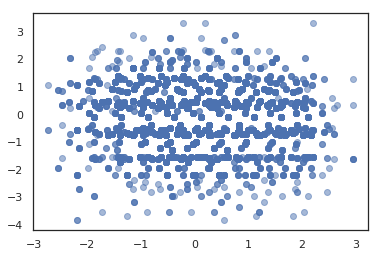

In [28]:
model = smf.ols('Fatigue_Z ~ RPE_Z', data=rpe)
res = model.fit()
plt.plot(rpe.RPE_Z, rpe.Fatigue_Z, 'o', alpha=.5)
# decorate(title='RPE vs next day fatigue', xlabel='RPE Z score',
#          ylabel='Fatigue Z score')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Soreness_Z   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     345.0
Date:                Fri, 12 Apr 2019   Prob (F-statistic):           2.97e-75
Time:                        00:52:53   Log-Likelihood:                -9703.3
No. Observations:                7163   AIC:                         1.941e+04
Df Residuals:                    7161   BIC:                         1.942e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3283      0.011    -29.623      0.000      -0.350      -0.307
RPE_Z         -0.2060      0.011    -18.574      0.000      -0.228      -0.184
==============================================================================
Omnibus:                       28.779   Durbin-Watson:                   0.747
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.074
Skew:                          -0.156   Prob(JB):                     4.86e-07
Kurtosis:                       2.993   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

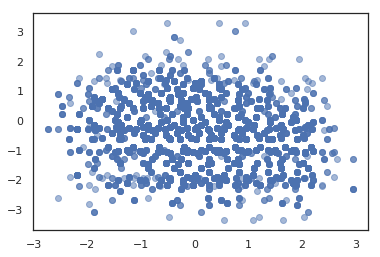

In [29]:
model = smf.ols('Soreness_Z ~ RPE_Z', data=rpe)
plt.plot(rpe.RPE_Z, rpe.Soreness_Z, 'o', alpha=.5)
# decorate(title='RPE vs next day soreness', xlabel='RPE Z score',
#          ylabel='Soreness Z score')
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Irritability_Z   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.678
Date:                Fri, 12 Apr 2019   Prob (F-statistic):              0.195
Time:                        00:52:53   Log-Likelihood:                -9702.5
No. Observations:                7163   AIC:                         1.941e+04
Df Residuals:                    7161   BIC:                         1.942e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0318      0.011     -2.867      0.004      -0.053      -0.010
RPE_Z         -0.0144      0.011     -1.295      0.195      -0.036       0.007
==============================================================================
Omnibus:                     2504.715   Durbin-Watson:                   0.776
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           141201.143
Skew:                          -0.874   Prob(JB):                         0.00
Kurtosis:                      24.681   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

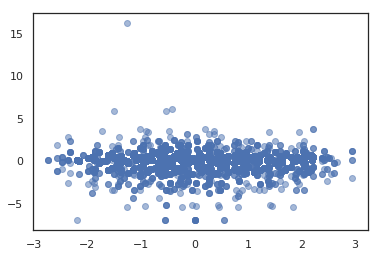

In [30]:
model = smf.ols('Irritability_Z ~ RPE_Z', data=rpe)
plt.plot(rpe.RPE_Z, rpe.Irritability_Z, 'o', alpha=.5)
# decorate(title='RPE vs next day irritability', xlabel='RPE Z score',
#          ylabel='Irritability Z score')
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Desire_Z   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     25.49
Date:                Fri, 12 Apr 2019   Prob (F-statistic):           4.56e-07
Time:                        00:52:53   Log-Likelihood:                -10021.
No. Observations:                7163   AIC:                         2.005e+04
Df Residuals:                    7161   BIC:                         2.006e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0069      0.012     -0.600      0.549      -0.030       0.016
RPE_Z         -0.0585      0.012     -5.049      0.000      -0.081      -0.036
==============================================================================
Omnibus:                      979.914   Durbin-Watson:                   0.650
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13420.956
Skew:                           0.019   Prob(JB):                         0.00
Kurtosis:                       9.706   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

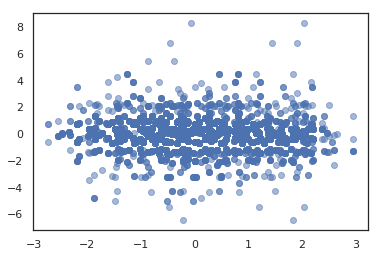

In [31]:
model = smf.ols('Desire_Z ~ RPE_Z', data=rpe)
plt.plot(rpe.RPE_Z, rpe.Desire_Z, 'o', alpha=.5)
# decorate(title='RPE vs next day desire', xlabel='RPE Z score',
#          ylabel='Desire Z score')
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SleepQuality_Z   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4611
Date:                Fri, 12 Apr 2019   Prob (F-statistic):              0.497
Time:                        00:52:53   Log-Likelihood:                -9838.3
No. Observations:                7163   AIC:                         1.968e+04
Df Residuals:                    7161   BIC:                         1.969e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0043      0.011      0.380      0.704      -0.018       0.026
RPE_Z         -0.0077      0.011     -0.679      0.497      -0.030       0.014
==============================================================================
Omnibus:                      753.362   Durbin-Watson:                   0.735
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1701.190
Skew:                          -0.643   Prob(JB):                         0.00
Kurtosis:                       5.012   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

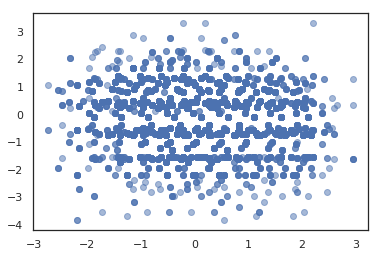

In [32]:
model = smf.ols('SleepQuality_Z ~ RPE_Z', data=rpe)
plt.plot(rpe.RPE_Z, rpe.Fatigue_Z, 'o', alpha=.5)
# decorate(title='RPE vs next day sleep quality', xlabel='RPE Z score',
#          ylabel='Sleep Quality Z score')
res = model.fit()
res.summary()

**Does type of workout and RPE tell you anything about wellness scores the next day**

In [33]:
rpe['SessionLoad_Z'] = rpe['Duration']*rpe['RPE_Z']

In [34]:
grouped = rpe.groupby('Date')

for i, row in rpe.iterrows():
    day = grouped.get_group(row['Date'])['SessionLoad_Z'].sum()
    rpe.at[i,'DailyLoad_Z'] = day

In [35]:
session_grouped = rpe.groupby('SessionType')
dependent_cols = ['Fatigue_Z', 'Soreness_Z', 'Desire_Z', 'Irritability_Z', 'SleepQuality_Z']
session_dict = dict()

for name, group in session_grouped:
    df = session_grouped.get_group(name)
    for col in dependent_cols:
        if col != 'Pain':
            model = smf.ols(col + ' ~ RPE_Z', data=df)
            res = model.fit()
            if res.rsquared > .1 or res.pvalues[1] < .05:
                session_dict[name + ' w/ ' + col + 'score'] = (model, res)
        else:
            model = smf.logit(col + ' ~ RPE_Z', data=df)
            res = model.fit()
            if res.prsquared > .1 or res.pvalues[1] < .05:
                session_dict[name + ' w/ ' + col] = (model, res)

for key, val in session_dict.items():
    if key[-4:] != 'Pain':
        session_dict[key] = [val[1].params[1], val[1].pvalues[1], val[1].rsquared]
    else:
        session_dict[key] = [val[1].params[1], val[1].pvalues[1], val[1].prsquared]
        
df = pd.DataFrame().from_dict(session_dict, orient='index', columns=['Coeff','P-Value','R^2'])
df

,Coeff,P-Value,R^2
Conditioning w/ Fatigue_Zscore,-0.098599,4.064158e-03,0.009279
Conditioning w/ Soreness_Zscore,-0.222908,2.170513e-11,0.049346
Conditioning w/ Desire_Zscore,-0.072315,2.708026e-02,0.005502
Conditioning w/ Irritability_Zscore,-0.079312,1.595185e-02,0.006538
Conditioning w/ SleepQuality_Zscore,-0.066923,3.125724e-02,0.005225
Game w/ Desire_Zscore,0.166197,1.102266e-02,0.014595
Skills w/ Soreness_Zscore,-0.129021,2.684950e-06,0.012513
Speed w/ Fatigue_Zscore,-0.230260,3.505873e-05,0.014734
Speed w/ Soreness_Zscore,-0.368329,8.376445e-13,0.043409
Speed w/ Desire_Zscore,-0.175839,4.784216e-04,0.010519


**Same as above, but trying to combine RPE and duration**

In [36]:
def standardize_col_dur(df, col):
        
        mean = df[col].mean()
        std = df[col].std()
        for i, row in df.iterrows():
            df.at[i, col+'_Z'] = (row[col]-mean)/std

In [37]:
session_grouped = rpe.groupby('SessionType')
dependent_cols = ['Fatigue_Z', 'Soreness_Z', 'Desire_Z', 'Irritability_Z', 'SleepQuality_Z']
session_dict = dict()

for name, group in session_grouped:
    df = session_grouped.get_group(name)
    standardize_col_dur(df, 'Duration')
    rpe_dur = df['RPE_Z']*df['Duration_Z']
    df['RPE_Dur'] = rpe_dur
    for col in dependent_cols:
        if col != 'Pain':
            model = smf.ols(col + ' ~ RPE_Dur', data=df)
            res = model.fit()
            if res.rsquared > .1 or res.pvalues[1] < .05:
                session_dict[name + '_' + col] = (model, res)
        else:
            model = smf.logit(col + ' ~ RPE_Dur', data=df)
            res = model.fit()
            if res.prsquared > .1 or res.pvalues[1] < .05:
                session_dict[name + '_' + col] = (model, res)

for key, val in session_dict.items():
    if key[-4:] != 'Pain':
        print(key + '\n' + str(val[1].rsquared) + '\n' + str(val[1].pvalues) +
              '\n' + str(val[1].params) + '\n----\n')
    else:
        print(key + '\n' + str(val[1].prsquared) + '\n' + str(val[1].pvalues) +
              '\n' + str(val[1].params) + '\n----\n')

/home/dconnolly/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/dconnolly/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/dconnolly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Mobility/Recovery_Soreness_Z
0.019651614520232563
Intercept    0.551323
RPE_Dur      0.000012
dtype: float64
Intercept   -0.017754
RPE_Dur     -0.097113
dtype: float64
----

Strength_Fatigue_Z
0.0032452339490428583
Intercept    0.010635
RPE_Dur      0.016320
dtype: float64
Intercept   -0.065963
RPE_Dur     -0.070873
dtype: float64
----

Strength_Soreness_Z
0.008966417410404715
Intercept    1.008679e-25
RPE_Dur      6.392488e-05
dtype: float64
Intercept   -0.253624
RPE_Dur     -0.109058
dtype: float64
----

Strength_Desire_Z
0.004039330927998019
Intercept    0.007091
RPE_Dur      0.007363
dtype: float64
Intercept   -0.062608
RPE_Dur     -0.071220
dtype: float64
----



In [38]:
gps.head()

,GameID,Date,Half,PlayerID,FrameID,Time,GameClock,Speed,AccelImpulse,AccelLoad,AccelX,AccelY,AccelZ,Longitude,Latitude
0,1,20171130,1,2,1,00:22:01,00:00:00,0.658334,0.611112,0.005330,0.13250,0.69875,0.56500,55.466666,24.994873
1,1,20171130,1,2,2,00:22:01,00:00:00,0.594445,0.638889,0.006568,0.11125,0.92000,0.70625,55.466666,24.994874
2,1,20171130,1,2,3,00:22:01,00:00:00,0.363889,2.305557,0.003114,0.01375,0.77000,0.67750,55.466667,24.994874
3,1,20171130,1,2,4,00:22:01,00:00:00,0.444445,0.805556,0.002602,0.00625,0.88625,0.59500,55.466667,24.994874
4,1,20171130,1,2,5,00:22:01,00:00:00,0.400000,0.444445,0.003813,-0.01750,0.85750,0.57375,55.466668,24.994874


We try to look into how the number of tackles/hits a player was involved in affected their health. For now, we use a rather simple model for a hit, as we assume any absolute change in velocity, or acceleration impulse, of more than 5.8 m/s^2 is a hit/tackle/encounter with another player. It is certainly possible that some of the hits are not from tackles, as they seem to occur in areas where the player does not change directions much at the spot where the acceleration happens. Additionally, it is possible to take a hit and continue moving. Future work could look into other ways of determining a hit.

The plots of latitude and longitude below are not particularly useful, but they do provide a sense of where the accelerations are happening.

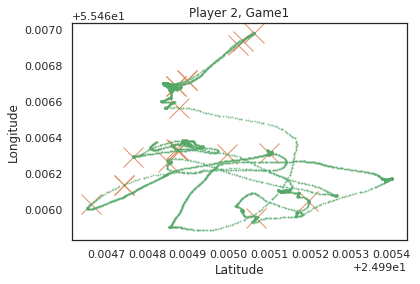

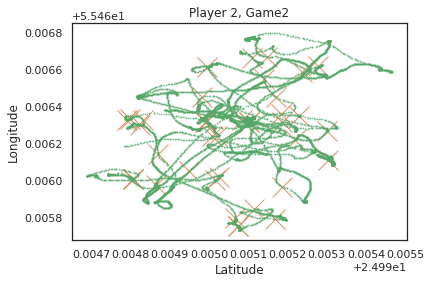

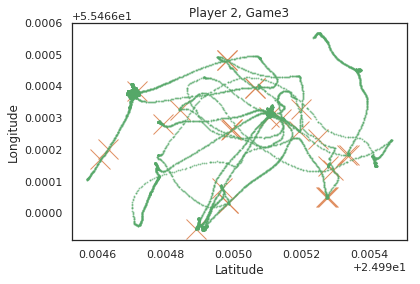

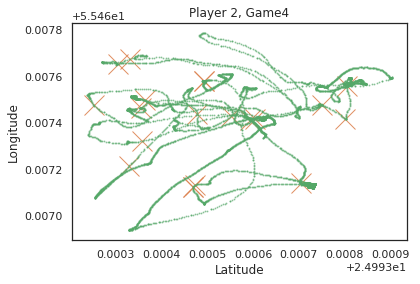

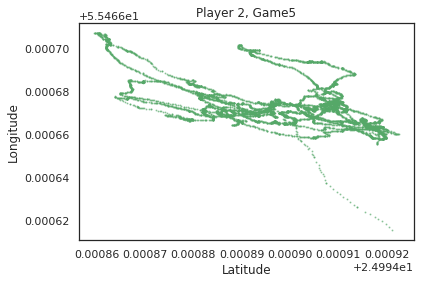

In [39]:
for num in np.arange(2,3):
    for gamenum in np.arange(1,6):
        p1 = gps[gps.PlayerID == num]
        p1 = p1[p1.GameID == gamenum]
        px = p1[p1.AccelImpulse > 5.8]
        l1 = px['Latitude']
        l2 = px['Longitude']
        plt.plot(l1,l2,'x',color='C1',alpha=0.9,markersize=20)
        lat = p1['Latitude']
        lon = p1['Longitude']
        plt.plot(lat,lon,'o',color='C2',alpha=0.5,markersize=1)
        plt.xlabel('Latitude')
        plt.ylabel('Longitude')
        plt.title('Player '+str(num)+', Game'+str(gamenum))
        plt.show()

We create a new dataframe containing the information on the number of significant accelerations a player experienced on a given day.

In [40]:
hits = pd.DataFrame()
# df['GameID'] = gps['GameID']    
hits['PlayerID'] = gps['PlayerID']
hits['Date'] = gps['Date']

# df = df.drop_duplicates(subset=['GameID', 'PlayerID', 'Date'], keep='first')
hits = hits.drop_duplicates(subset=['PlayerID', 'Date'], keep='first')

hits['hits'] = 0

for i, row in hits.iterrows():
    p1 = gps[gps.PlayerID == row.PlayerID]
    p1 = p1[p1.Date == row.Date]
    hit = len(p1[p1.AccelImpulse > 5.8])
    hits.at[i, 'hits'] = hit

In [41]:
hits.head()

,PlayerID,Date,hits
0,2,20171130,87
5257,3,20171130,50
10514,4,20171130,77
15771,6,20171130,48
21028,7,20171130,50


We can combine this with the wellness data as well.

In [42]:
x = pd.merge(hits, well2, on=['PlayerID', 'Date'])

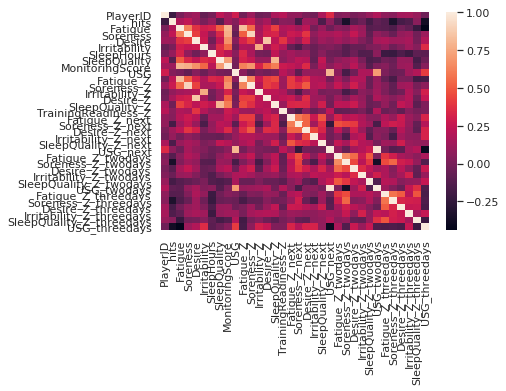

In [43]:
corr = x.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [44]:
model = smf.ols('Soreness_Z_next ~ hits', data=x)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Soreness_Z_next   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     5.348
Date:                Fri, 12 Apr 2019   Prob (F-statistic):             0.0220
Time:                        00:53:07   Log-Likelihood:                -244.21
No. Observations:                 167   AIC:                             492.4
Df Residuals:                     165   BIC:                             498.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4659      0.171     -2.728      0.007      -0.803      -0.129
hits          -0.0080      0.003     -2.313      0.022      -0.015      -0.001
==============================================================================
Omnibus:                        3.121   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.210   Jarque-Bera (JB):                2.659
Skew:                           0.279   Prob(JB):                        0.265
Kurtosis:                       3.265   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

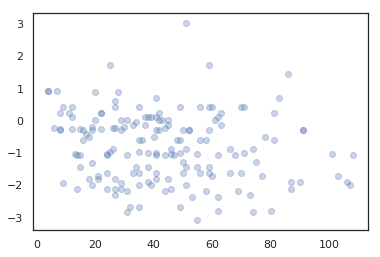

In [45]:
plt.plot(x.hits, x.Soreness_Z_next, 'o',alpha=0.3)

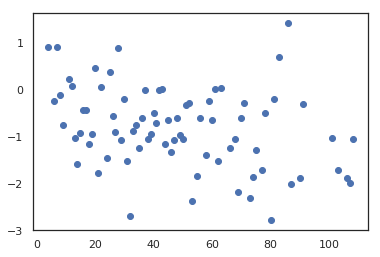

In [46]:
grouped = x.groupby('hits')
series = grouped['Soreness_Z_next'].mean()
plt.plot(series,'o')

Text(0.5, 1.0, 'Soreness Rating Next Day vs. Potential Hits')

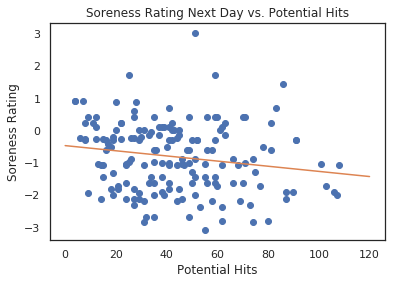

In [47]:
df = pd.DataFrame()
df['hits'] = np.linspace(0,120)
# df['fat2'] = df['Fatigue']**2
# plt.plot(hits_by_fatz, 'o', alpha=0.5)
plt.plot(x.hits, x.Soreness_Z_next,'o')
pred = res.predict(df)
plt.plot(df['hits'], pred)
sns.set(style="darkgrid", palette='bright',color_codes=True)
plt.xlabel('Potential Hits')
plt.ylabel('Soreness Rating')
plt.title('Soreness Rating Next Day vs. Potential Hits')

In [48]:
columns = ['Fatigue_Z', 'Soreness_Z', 'Irritability_Z', 'Desire_Z',
       'SleepQuality_Z', 'TrainingReadiness_Z', 'Fatigue_Z_next',
       'Soreness_Z_next', 'Desire_Z_next', 'Irritability_Z_next',
       'SleepQuality_Z_next', 'USG_next', 'Fatigue_Z_twodays',
       'Soreness_Z_twodays', 'Desire_Z_twodays', 'Irritability_Z_twodays',
       'SleepQuality_Z_twodays', 'USG_twodays', 'Fatigue_Z_threedays',
       'Soreness_Z_threedays', 'Desire_Z_threedays',
       'Irritability_Z_threedays', 'SleepQuality_Z_threedays',
       'USG_threedays']

In [49]:
for col in columns:
    model = smf.ols(col + ' ~ hits', data=x)
    res = model.fit()
    print(col)
    print("PVal: ", res.pvalues)
    print("Rsquared: ", res.rsquared)

Fatigue_Z
PVal:  Intercept    0.071620
hits         0.000956
dtype: float64
Rsquared:  0.054016286496747834
Soreness_Z
PVal:  Intercept    0.002402
hits         0.000061
dtype: float64
Rsquared:  0.07847158765587348
Irritability_Z
PVal:  Intercept    0.502677
hits         0.233126
dtype: float64
Rsquared:  0.007208888585039985
Desire_Z
PVal:  Intercept    0.000426
hits         0.022540
dtype: float64
Rsquared:  0.02613379065083421
SleepQuality_Z
PVal:  Intercept    0.127361
hits         0.734562
dtype: float64
Rsquared:  0.0005848848087948166
TrainingReadiness_Z
PVal:  Intercept    0.019528
hits         0.415617
dtype: float64
Rsquared:  0.0033666988221909833
Fatigue_Z_next
PVal:  Intercept    0.002145
hits         0.519700
dtype: float64
Rsquared:  0.0025164974344664692
Soreness_Z_next
PVal:  Intercept    0.007055
hits         0.021977
dtype: float64
Rsquared:  0.03139633032542
Desire_Z_next
PVal:  Intercept    0.816242
hits         0.102702
dtype: float64
Rsquared:  0.016058425190611

It appears that the relationship between soreness and hits is the most statistically significant. This seems to give delayed onset muscle soreness validity, as the soreness-hits relationship is most significant the second day after the hit takes place.

In [50]:
model = smf.ols('Soreness_Z_twodays ~ hits', data=x)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Soreness_Z_twodays   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     18.10
Date:                Fri, 12 Apr 2019   Prob (F-statistic):           3.84e-05
Time:                        00:53:08   Log-Likelihood:                -204.84
No. Observations:                 141   AIC:                             413.7
Df Residuals:                     139   BIC:                             419.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1214      0.192     -0.633      0.528      -0.500       0.258
hits          -0.0170      0.004     -4.254      0.000      -0.025      -0.009
==============================================================================
Omnibus:                       16.987   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.708
Skew:                           0.665   Prob(JB):                     7.11e-06
Kurtosis:                       4.506   Cond. No.                         105.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

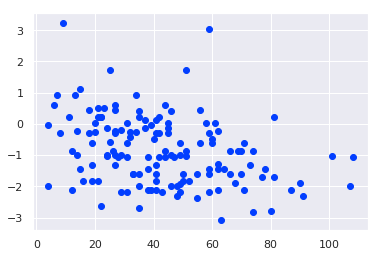

In [51]:
plt.plot(x.hits, x.Soreness_Z_twodays, 'o')

Text(0, 0.5, 'Standardized Soreness Rating')

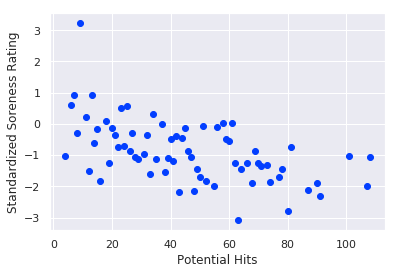

In [52]:
grouped = x.groupby('hits')
hits_by_fatz = grouped['Soreness_Z_twodays'].mean()
plt.plot(hits_by_fatz, 'o')
plt.xlabel('Potential Hits')
plt.ylabel('Standardized Soreness Rating')

Text(0.5, 1.0, 'Soreness Rating Two Days Later vs. Potential Hits')

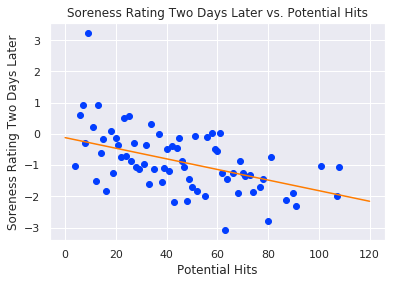

In [53]:
df = pd.DataFrame()
df['hits'] = np.linspace(0,120)
# plt.plot(x.hits, x.Soreness_Z_next,'o')
plt.plot(hits_by_fatz, 'o')
pred = res.predict(df)
plt.plot(df['hits'], pred)
sns.set(style="darkgrid", palette='bright',color_codes=True)
plt.xlabel('Potential Hits')
plt.ylabel('Soreness Rating Two Days Later')
plt.title('Soreness Rating Two Days Later vs. Potential Hits')

In [54]:
model = smf.ols('Soreness_Z_threedays ~ hits', data=x)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Soreness_Z_threedays   R-squared:                       0.104
Model:                              OLS   Adj. R-squared:                  0.098
Method:                   Least Squares   F-statistic:                     16.61
Date:                  Fri, 12 Apr 2019   Prob (F-statistic):           7.59e-05
Time:                          00:53:08   Log-Likelihood:                -204.20
No. Observations:                   145   AIC:                             412.4
Df Residuals:                       143   BIC:                             418.4
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1298      0.173      0.752      0.453      -0.211       0.471
hits          -0.0142      0.003     -4.075      0.000      -0.021      -0.007
==============================================================================
Omnibus:                        9.257   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               10.802
Skew:                           0.437   Prob(JB):                      0.00451
Kurtosis:                       4.012   Cond. No.                         103.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The pvalue remains small on the third day after the hit, but the r-squared value drops on the third day after the hit.

Text(0, 0.5, 'Standardized Soreness Rating')

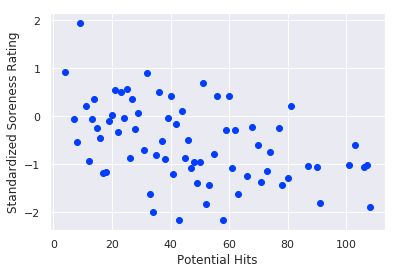

In [55]:
grouped = x.groupby('hits')
hits_by_fatz = grouped['Soreness_Z_threedays'].mean()
plt.plot(hits_by_fatz, 'o')
plt.xlabel('Potential Hits')
plt.ylabel('Standardized Soreness Rating')

Text(0.5, 1.0, 'Potential Hits vs. Soreness Rating Three Days Later')

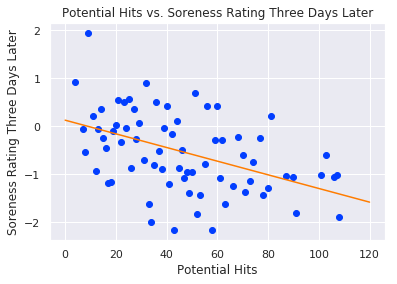

In [56]:
df = pd.DataFrame()
df['hits'] = np.linspace(0,120)
# plt.plot(x.hits, x.Soreness_Z_next,'o')
plt.plot(hits_by_fatz, 'o')
pred = res.predict(df)
plt.plot(df['hits'], pred)
sns.set(style="darkgrid", palette='bright',color_codes=True)
plt.xlabel('Potential Hits')
plt.ylabel('Soreness Rating Three Days Later')
plt.title('Potential Hits vs. Soreness Rating Three Days Later')

We next decided to visualize some of the data we were looking at further to potentially generate some new ideas for direction.

/home/dconnolly/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


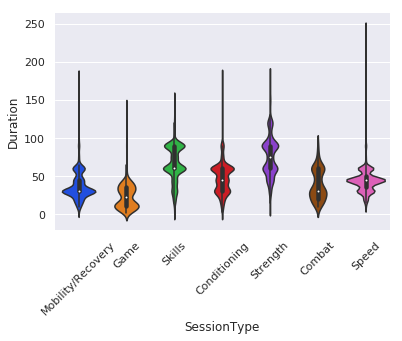

In [57]:
data = rpe.dropna(subset=['Duration', 'SessionType'])
sns.violinplot(x='SessionType', y='Duration', data=data, whis=10)
sns.set(style="whitegrid", palette="pastel", color_codes=True)


sns.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.xlabel('SessionType')
plt.ylabel('Duration');

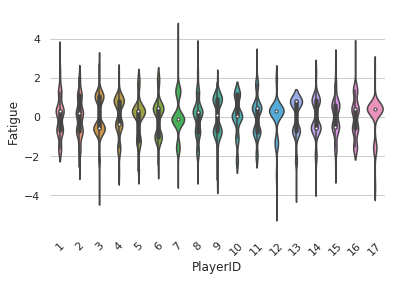

In [58]:
data = wellness.dropna(subset=['PlayerID', 'Fatigue_Z'])
sns.violinplot(x='PlayerID', y='Fatigue_Z', data=data, whis=100)
sns.set(style="whitegrid", palette="pastel", color_codes=True)


sns.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.xlabel('PlayerID')
plt.ylabel('Fatigue');

The plot below suggests that women on the team that were menstruating experienced a higher number of 'hits' than the other women on the team. We'll need to change the axes labels once we come to a final decision on what to define as a hit and/or what to call a high Acceleration Impulse. Note: Right now, the axes labels for potential hits/tackles/AccelImpulses are somewhat inconsistent. We'll fix that later.

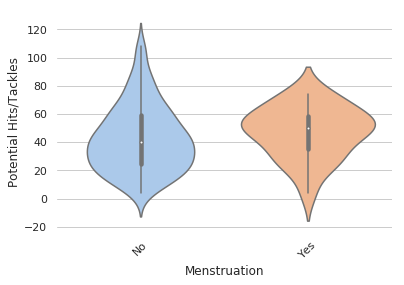

In [59]:
data = x.dropna(subset=['Menstruation', 'hits'])
sns.violinplot(x='Menstruation', y='hits', data=data, whis=10)
sns.set(style="whitegrid", palette="pastel", color_codes=True)


sns.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.xlabel('Menstruation')
plt.ylabel('Potential Hits/Tackles');

As long as the women are getting okay nutrtion, they seem to be involved in the same amount of potential hits/tackles as those getting excellent nutrition.

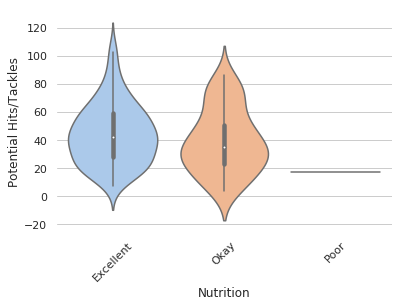

In [60]:
data = x.dropna(subset=['Nutrition', 'hits'])
sns.violinplot(x='Nutrition', y='hits', data=data, whis=10)
sns.set(style="whitegrid", palette="pastel", color_codes=True)


sns.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.xlabel('Nutrition')
plt.ylabel('Potential Hits/Tackles');

The plot below shows that those who felt slightly off were slightly more likely to experience large accelerations in games than the other women on the team.

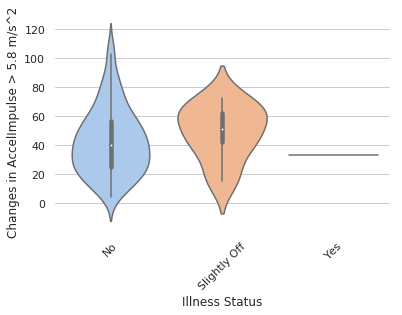

In [61]:
data = x.dropna(subset=['Illness', 'hits'])
sns.violinplot(x='Illness', y='hits', data=data, whis=10)
sns.set(style="whitegrid", palette="pastel", color_codes=True)


sns.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.xlabel('Illness Status')
plt.ylabel('Changes in AccelImpulse > 5.8 m/s^2');

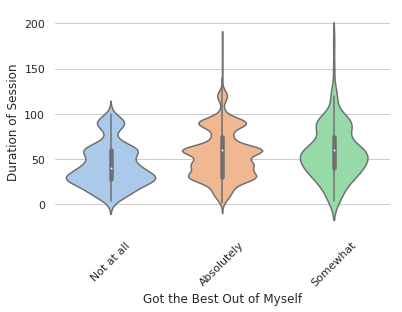

In [62]:
data = rpe.dropna(subset=['BestOutOfMyself', 'Duration'])
sns.violinplot(x='BestOutOfMyself', y='Duration', data=data, whis=10)
sns.set(style="whitegrid", palette="pastel", color_codes=True)


sns.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.xlabel('Got the Best Out of Myself')
plt.ylabel('Duration of Session');

Since sleep is generally regarded as a huge factor in how tired people feel, we look into this dataset to see if that holds true.

In [63]:
formula = 'Fatigue_Z_next ~ SleepQuality_Z'
results = smf.ols(formula,data=x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Fatigue_Z_next   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     20.98
Date:                Fri, 12 Apr 2019   Prob (F-statistic):           9.10e-06
Time:                        00:53:09   Log-Likelihood:                -256.85
No. Observations:                 167   AIC:                             517.7
Df Residuals:                     165   BIC:                             523.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.4120      0.090     -4.593      0.000      -0.589      -0.235
SleepQuality_Z     0.4560      0.100      4.580      0.000       0.259       0.653
==============================================================================
Omnibus:                        1.958   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.376   Jarque-Bera (JB):                1.959
Skew:                          -0.258   Prob(JB):                        0.375
Kurtosis:                       2.873   Cond. No.                         1.27
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It appears that there is a positive trend in the data. Note that a +2 in fatigue represents feeling fresher than usual, while a -3 represents feeling exhausted. A +2 in sleep quality deep and restful sleep, while -3 means the athlete experienced restless sleep.

Text(0, 0.5, 'Fatigue Rating Next Day')

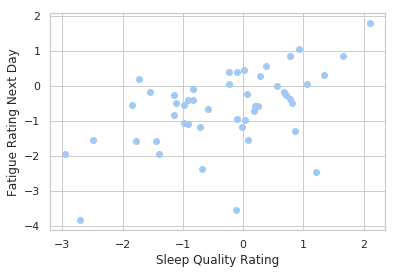

In [64]:
grouped = x.groupby('SleepQuality_Z')
hits_by_fatz = grouped['Fatigue_Z_next'].mean()
plt.plot(hits_by_fatz, 'o')
plt.xlabel('Sleep Quality Rating')
plt.ylabel('Fatigue Rating Next Day')

Text(0.5, 1.0, 'Fatigue Rating Next Day vs. Sleep Quality Rating')

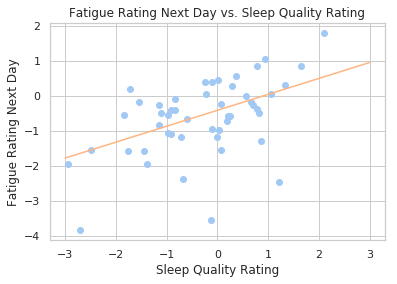

In [65]:
df = pd.DataFrame()
df['SleepQuality_Z'] = np.linspace(-3,3)
plt.plot(hits_by_fatz, 'o')
pred = results.predict(df)
plt.plot(df['SleepQuality_Z'], pred)
sns.set(style="darkgrid", palette='bright',color_codes=True)
plt.xlabel('Sleep Quality Rating')
plt.ylabel('Fatigue Rating Next Day')
plt.title('Fatigue Rating Next Day vs. Sleep Quality Rating')

In [66]:
formula = 'Fatigue_Z_twodays ~ SleepQuality_Z'
results = smf.ols(formula,data=x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Fatigue_Z_twodays   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     8.016
Date:                Fri, 12 Apr 2019   Prob (F-statistic):            0.00532
Time:                        00:53:10   Log-Likelihood:                -222.15
No. Observations:                 141   AIC:                             448.3
Df Residuals:                     139   BIC:                             454.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.7875      0.105     -7.534      0.000      -0.994      -0.581
SleepQuality_Z     0.3348      0.118      2.831      0.005       0.101       0.569
==============================================================================
Omnibus:                        1.153   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.562   Jarque-Bera (JB):                0.774
Skew:                           0.151   Prob(JB):                        0.679
Kurtosis:                       3.201   Cond. No.                         1.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Fatigue Rating Two Days Later')

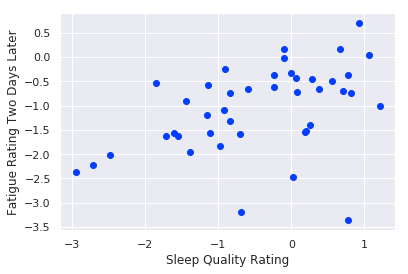

In [67]:
grouped = x.groupby('SleepQuality_Z')
hits_by_fatz = grouped['Fatigue_Z_twodays'].mean()
plt.plot(hits_by_fatz, 'o')
plt.xlabel('Sleep Quality Rating')
plt.ylabel('Fatigue Rating Two Days Later')

Text(0.5, 1.0, 'Fatigue Rating Two Days Later vs. Sleep Quality Rating')

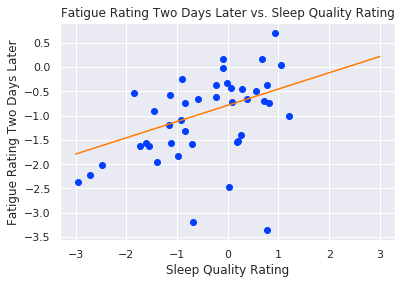

In [68]:
df = pd.DataFrame()
df['SleepQuality_Z'] = np.linspace(-3,3)
plt.plot(hits_by_fatz, 'o')
pred = results.predict(df)
plt.plot(df['SleepQuality_Z'], pred)
sns.set(style="darkgrid", palette='bright',color_codes=True)
plt.xlabel('Sleep Quality Rating')
plt.ylabel('Fatigue Rating Two Days Later')
plt.title('Fatigue Rating Two Days Later vs. Sleep Quality Rating')

In [69]:
formula = 'Fatigue_Z ~ SleepQuality_Z'
results = smf.ols(formula,data=x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Fatigue_Z   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     50.39
Date:                Fri, 12 Apr 2019   Prob (F-statistic):           2.23e-11
Time:                        00:53:10   Log-Likelihood:                -279.13
No. Observations:                 199   AIC:                             562.3
Df Residuals:                     197   BIC:                             568.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.3295      0.073      4.526      0.000       0.186       0.473
SleepQuality_Z     0.5357      0.075      7.098      0.000       0.387       0.685
==============================================================================
Omnibus:                        1.013   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.603   Jarque-Bera (JB):                0.982
Skew:                          -0.170   Prob(JB):                        0.612
Kurtosis:                       2.943   Cond. No.                         1.32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Fatigue Rating Same Day')

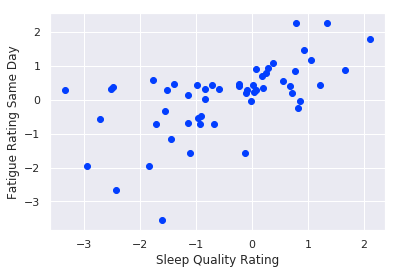

In [70]:
grouped = x.groupby('SleepQuality_Z')
hits_by_fatz = grouped['Fatigue_Z'].mean()
plt.plot(hits_by_fatz, 'o')
plt.xlabel('Sleep Quality Rating')
plt.ylabel('Fatigue Rating Same Day')

Sleep Quality seems to affect the athlete's level of fatigue most on the day immediately following poor sleep. This is unsurprising but good to confirm and inform our investigation of delayed onset muscle soreness.

Text(0.5, 1.0, 'Fatigue Rating Same Day vs. Sleep Quality Rating')

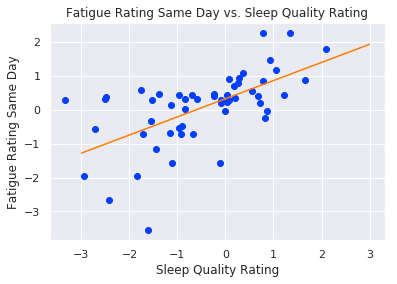

In [71]:
df = pd.DataFrame()
df['SleepQuality_Z'] = np.linspace(-3,3)
plt.plot(hits_by_fatz, 'o')
pred = results.predict(df)
plt.plot(df['SleepQuality_Z'], pred)
sns.set(style="darkgrid", palette='bright',color_codes=True)
plt.xlabel('Sleep Quality Rating')
plt.ylabel('Fatigue Rating Same Day')
plt.title('Fatigue Rating Same Day vs. Sleep Quality Rating')

Below, we can see that the athletes tend to rate their perceived effort slightly above average in the longest sessions. It appears to be a concave-down parabola, so we will try to fit a parabola to it.

Text(0.5, 1.0, 'Duration of Session vs. RPE_Z')

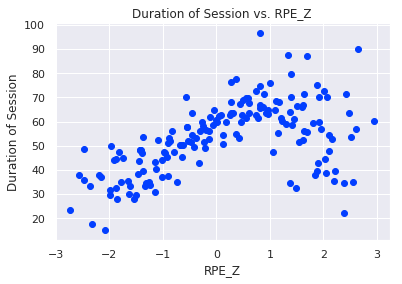

In [72]:
grouped = rpe.groupby('RPE_Z')
duration_by_rpe = grouped['Duration'].mean()
plt.plot(duration_by_rpe, 'o')
plt.xlabel('RPE_Z')
plt.ylabel('Duration of Session')
plt.title('Duration of Session vs. RPE_Z')

In [73]:
xrpe = rpe
xrpe['rpe2'] = xrpe['RPE_Z']**2
model = smf.ols('Duration ~ RPE_Z + rpe2', data=xrpe)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Duration   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     451.4
Date:                Fri, 12 Apr 2019   Prob (F-statistic):          5.64e-186
Time:                        00:53:10   Log-Likelihood:                -35434.
No. Observations:                7621   AIC:                         7.087e+04
Df Residuals:                    7618   BIC:                         7.090e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.7426      0.369    162.019      0.000      59.020      60.465
RPE_Z          7.7982      0.294     26.563      0.000       7.223       8.374
rpe2          -4.0957      0.228    -17.925      0.000      -4.544      -3.648
==============================================================================
Omnibus:                      434.823   Durbin-Watson:                   1.746
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              599.734
Skew:                           0.522   Prob(JB):                    5.88e-131
Kurtosis:                       3.894   Cond. No.                         2.47
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
df = pd.DataFrame()
df['RPE_Z'] = np.linspace(-3,3)
df['rpe2'] = df['RPE_Z']**2

The parabola doesn't fit the data perfectly, but considering we are plotting mean durations and not the durations of each individual session, it is likely that our parabola fits the data better than we think. It does seem to model the data fairly well.

Text(0.5, 1.0, 'Duration of Session vs. RPE')

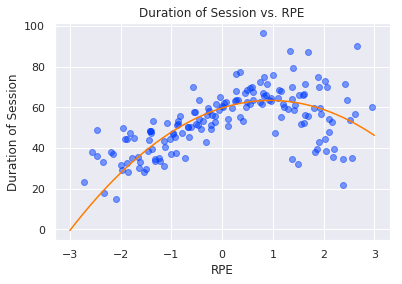

In [75]:
plt.plot(duration_by_rpe, 'o', alpha=0.5)
pred = res.predict(df)
plt.plot(df['RPE_Z'], pred)
sns.set(style="darkgrid", palette='bright',color_codes=True)
plt.xlabel('RPE')
plt.ylabel('Duration of Session')
plt.title('Duration of Session vs. RPE')

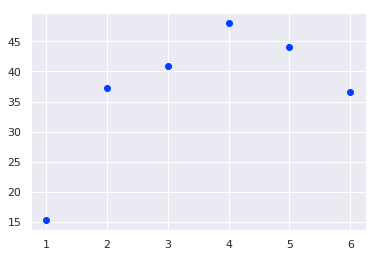

In [76]:
grouped = x.groupby('Fatigue')
hits_by_fat = grouped['hits'].mean()
plt.plot(hits_by_fat, 'o')

In [77]:
xwell = x
xwell['fat2'] = xwell['Fatigue']**2
model = smf.ols('hits ~ Fatigue + fat2', data=xwell)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   hits   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     5.644
Date:                Fri, 12 Apr 2019   Prob (F-statistic):            0.00414
Time:                        00:53:11   Log-Likelihood:                -898.30
No. Observations:                 199   AIC:                             1803.
Df Residuals:                     196   BIC:                             1812.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0237     14.865     -0.069      0.945     -30.340      28.293
Fatigue       22.8177      8.808      2.590      0.010       5.446      40.189
fat2          -2.7136      1.274     -2.129      0.034      -5.227      -0.200
==============================================================================
Omnibus:                        8.184   Durbin-Watson:                   1.215
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.592
Skew:                           0.503   Prob(JB):                       0.0136
Kurtosis:                       2.839   Cond. No.                         163.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It appears that the potential hits also have a parabolic relationship with the fatigue ratings.

Text(0.5, 1.0, 'Potential Hits vs. Fatigue Rating')

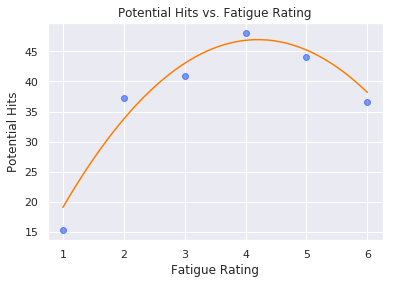

In [78]:
df = pd.DataFrame()
df['Fatigue'] = np.linspace(1,6)
df['fat2'] = df['Fatigue']**2
plt.plot(hits_by_fat, 'o', alpha=0.5)
pred = res.predict(df)
plt.plot(df['Fatigue'], pred)
sns.set(style="darkgrid", palette='bright',color_codes=True)
plt.ylabel('Potential Hits')
plt.xlabel('Fatigue Rating')
plt.title('Potential Hits vs. Fatigue Rating')

We now observe the relationship between the standardized fatigue ratings and the potential hits.

Text(0.5, 0, 'Standardized Fatigue Rating')

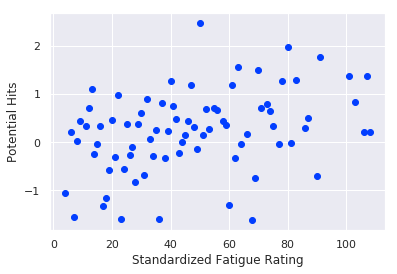

In [79]:
grouped = x.groupby('hits')
hits_by_fatz = grouped['Fatigue_Z'].mean()
plt.plot(hits_by_fatz, 'o')
plt.ylabel('Potential Hits')
plt.xlabel('Standardized Fatigue Rating')

The P Value is small, but so is the R-Squared. It seems that there is a relationship, albeit not necessarily one that our model explains particularly well.

In [80]:
model = smf.ols('Fatigue_Z ~ hits', data=x)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Fatigue_Z   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     11.25
Date:                Fri, 12 Apr 2019   Prob (F-statistic):           0.000956
Time:                        00:53:11   Log-Likelihood:                -296.26
No. Observations:                 199   AIC:                             596.5
Df Residuals:                     197   BIC:                             603.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2973      0.164     -1.811      0.072      -0.621       0.026
hits           0.0113      0.003      3.354      0.001       0.005       0.018
==============================================================================
Omnibus:                        3.579   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.167   Jarque-Bera (JB):                3.162
Skew:                          -0.282   Prob(JB):                        0.206
Kurtosis:                       3.252   Cond. No.                         105.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As the number of potential hits increases, the fatigue rating the next day also increases. The more positive the fatigue rating, the fresher the athlete is feeling.

Text(0.5, 1.0, 'Potential Hits vs. Fatigue Rating')

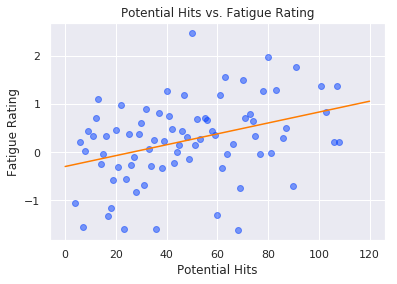

In [81]:
df = pd.DataFrame()
df['hits'] = np.linspace(0,120)
# df['fat2'] = df['Fatigue']**2
plt.plot(hits_by_fatz, 'o', alpha=0.5)
pred = res.predict(df)
plt.plot(df['hits'], pred)
sns.set(style="darkgrid", palette='bright',color_codes=True)
plt.xlabel('Potential Hits')
plt.ylabel('Fatigue Rating')
plt.title('Potential Hits vs. Fatigue Rating')

In [82]:
x.head()

,PlayerID,Date,hits,Fatigue,Soreness,Desire,Irritability,BedTime,WakeTime,SleepHours,...,Irritability_Z_twodays,SleepQuality_Z_twodays,USG_twodays,Fatigue_Z_threedays,Soreness_Z_threedays,Desire_Z_threedays,Irritability_Z_threedays,SleepQuality_Z_threedays,USG_threedays,fat2
0,2,20171130,87,4,4,5,4,21:15:00,06:00:00,8.75,...,NaN,NaN,NaN,0.207884,-1.060907,-1.234229,-0.186841,-0.100390,NaN,16
1,3,20171130,50,5,4,6,4,21:30:00,05:30:00,8.00,...,0.143069,-2.711368,NaN,-0.578512,-0.279482,-0.629923,0.143069,-2.711368,NaN,25
2,4,20171130,77,3,6,6,5,01:00:00,07:15:00,6.25,...,-0.940299,-0.707157,NaN,-0.374305,0.507847,0.095762,0.463336,0.774277,NaN,9
3,6,20171130,48,4,4,4,4,22:00:00,07:15:00,9.25,...,0.145116,0.022630,NaN,-1.012796,-0.609797,0.126636,0.145116,1.212985,NaN,16
4,7,20171130,50,5,4,6,4,21:00:00,06:00:00,9.00,...,-1.334150,-1.150014,NaN,-1.544021,-1.613439,-3.073898,-1.334150,0.187121,NaN,25


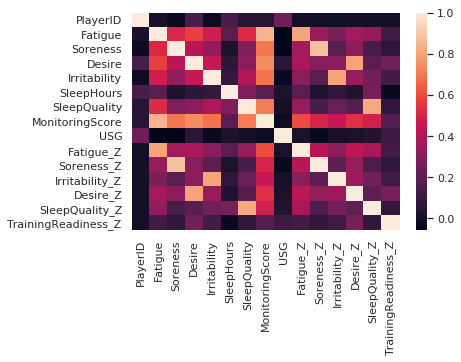

In [83]:
corr = wellness.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

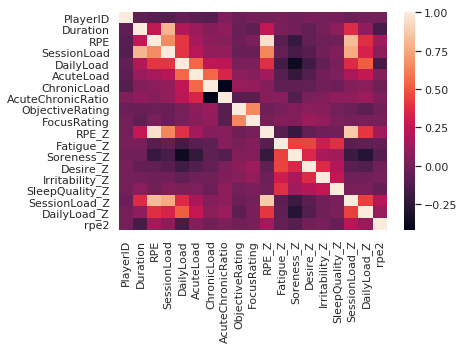

In [84]:
corr = rpe.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

Below, USG means urine specific gravity. Above 1.025 indicates mild dehydration according to the codebook.

Text(0.5, 1.0, 'USG vs. potential hits')

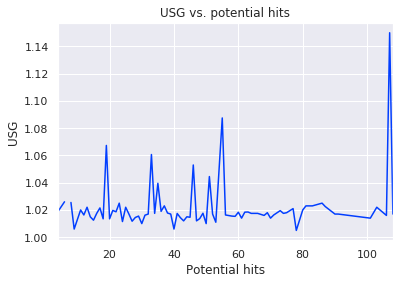

In [85]:
grouped = x.groupby('hits')
series = grouped['USG'].mean()
series.plot()
plt.xlabel('Potential hits')
plt.ylabel('USG')
plt.title('USG vs. potential hits')

In [86]:
rpe.head()

,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,...,BestOutOfMyself,RPE_Z,Fatigue_Z,Soreness_Z,Desire_Z,Irritability_Z,SleepQuality_Z,SessionLoad_Z,DailyLoad_Z,rpe2
0,20180721,13,Yes,Mobility/Recovery,5.0,0.0,0.0,446.0,323.1,303.25,...,Not at all,-1.253472,NaN,NaN,NaN,NaN,NaN,-6.267360,76.876042,1.571192
1,20180721,13,Yes,Game,29.0,7.0,203.0,NaN,NaN,NaN,...,Not at all,1.153176,NaN,NaN,NaN,NaN,NaN,33.442093,76.876042,1.329814
2,20180721,13,Yes,Game,27.0,9.0,243.0,NaN,NaN,NaN,...,Not at all,1.840789,NaN,NaN,NaN,NaN,NaN,49.701309,76.876042,3.388505
3,20180720,11,Yes,Game,36.0,6.0,216.0,534.0,256.3,344.18,...,Absolutely,0.750374,1.671003,0.426559,2.815371,0.652563,-0.230249,27.013469,99.695812,0.563061
4,20180720,11,Yes,Game,36.0,8.0,288.0,NaN,NaN,NaN,...,Absolutely,1.695403,1.671003,0.426559,2.815371,0.652563,-0.230249,61.034502,99.695812,2.874391


In [87]:
grouped = rpe.groupby(['PlayerID','Date'])
series = grouped['RPE_Z'].mean()
series
rpe2 = pd.merge(rpe, series, on=['PlayerID', 'Date'])
rpe2[rpe2.Date == 20180717].head()

,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,...,RPE_Z_x,Fatigue_Z,Soreness_Z,Desire_Z,Irritability_Z,SleepQuality_Z,SessionLoad_Z,DailyLoad_Z,rpe2,RPE_Z_y
29,20180717,1,Yes,Skills,60.0,3.0,180.0,195.0,62.1,173.93,...,-0.254554,0.318219,0.700575,0.450886,-3.093934,0.373368,-15.273230,-49.675206,0.064798,-1.055550
30,20180717,1,Yes,Mobility/Recovery,30.0,0.0,15.0,NaN,NaN,NaN,...,-1.856546,0.318219,0.700575,0.450886,-3.093934,0.373368,-55.696380,-49.675206,3.446763,-1.055550
31,20180717,2,Yes,Skills,60.0,4.0,240.0,280.0,181.4,349.07,...,-0.132440,1.123116,0.600282,0.991322,-0.186841,1.520190,-7.946414,-49.675206,0.017540,-0.955462
32,20180717,2,Yes,Mobility/Recovery,40.0,1.0,40.0,NaN,NaN,NaN,...,-1.778483,1.123116,0.600282,0.991322,-0.186841,1.520190,-71.139321,-49.675206,3.163002,-0.955462
33,20180717,3,Yes,Skills,75.0,5.0,375.0,375.0,190.7,392.61,...,0.002287,1.058254,-0.279482,0.757503,0.143069,0.255789,0.171557,-49.675206,0.000005,0.002287


Text(0, 0.5, 'RPE_Z')

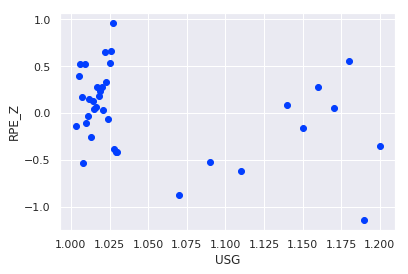

In [88]:
y = pd.merge(wellness[['USG','Date','PlayerID']], rpe2, on=['Date','PlayerID'])
grouped = y.groupby('USG')
rpe_by_usg = grouped['RPE_Z_y'].mean()
plt.plot(rpe_by_usg,'o')
plt.xlabel('USG')
plt.ylabel('RPE_Z')

In [89]:
y['usg2'] = y['USG']**2

The p value below is large, so this relationship is probably meaningless. The distribution looked somewhat parabolic, but there are so many more data points near 1.0 on the x axis that the model actually just looked like a line when plotted.

In [90]:
model = smf.ols('RPE_Z_y ~ USG + usg2', data=y)
res2 = model.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                RPE_Z_y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.117
Date:                Fri, 12 Apr 2019   Prob (F-statistic):              0.121
Time:                        00:53:12   Log-Likelihood:                -1169.4
No. Observations:                1021   AIC:                             2345.
Df Residuals:                    1018   BIC:                             2360.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.9227     25.540      0.193      0.847     -45.194      55.039
USG           -7.3979     47.045     -0.157      0.875     -99.715      84.919
usg2           2.6584     21.570      0.123      0.902     -39.668      44.985
==============================================================================
Omnibus:                        7.419   Durbin-Watson:                   0.667
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                7.092
Skew:                           0.168   Prob(JB):                       0.0288
Kurtosis:                       2.767   Cond. No.                     4.29e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Below, we look at how speed changes over the course of a half. (The frameid restarts at 0 at the beginning of each half)

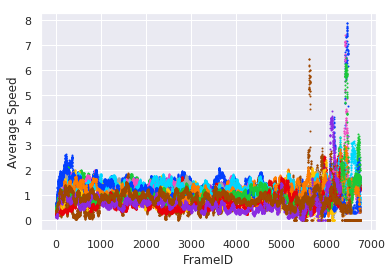

In [91]:
for playerid in np.arange(1,17):
    gpsx = gps[gps.PlayerID == playerid]
    grouped = gpsx.groupby('FrameID')
    series = grouped['Speed'].mean()
    plt.plot(series, 'o', markersize=1)
plt.xlabel('FrameID')
plt.ylabel('Average Speed')
plt.show()

We fit several polynomial curves to the data for each player to see how average speed changes over the course of a half. We tried many different degrees of polynomials; none produced usable results.

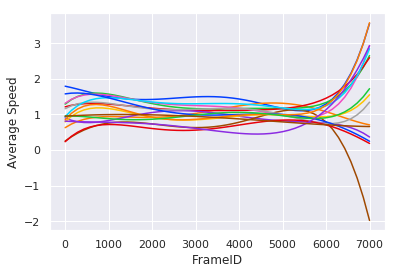

In [92]:
for playerid in np.arange(1,17):
    gpsx = gps[gps.PlayerID == playerid]
    grouped = gpsx.groupby('FrameID')
    series = grouped['Speed'].mean()
    coefs = np.polyfit(gpsx.FrameID, gpsx.Speed,5)
    p = np.polyval(coefs, np.linspace(0,7000))
    plt.plot(np.linspace(0,7000),p)
plt.xlabel('FrameID')
plt.ylabel('Average Speed')
plt.show()

Below, a higher order polynomial:

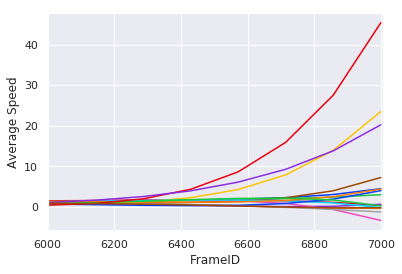

In [93]:
for playerid in np.arange(1,17):
    gpsx = gps[gps.PlayerID == playerid]
    grouped = gpsx.groupby('FrameID')
    series = grouped['Speed'].mean()
    coefs = np.polyfit(gpsx.FrameID, gpsx.Speed,9)
    p = np.polyval(coefs, np.linspace(0,7000))
    plt.plot(np.linspace(0,7000),p)
plt.xlabel('FrameID')
plt.xlim(6000,7005)
plt.ylabel('Average Speed')
plt.show()

Finally, we observed that, unsurprisingly, the magnitude of the player's accelerations followed a similar trend over the course of the game as their speeds.

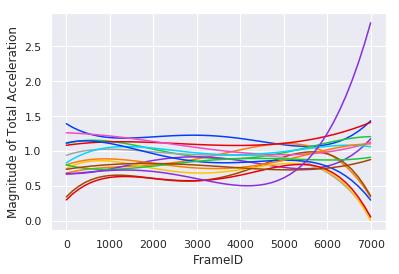

In [94]:
for playerid in np.arange(1,17):
    gpsx = gps[gps.PlayerID == playerid]
    grouped = gpsx.groupby('FrameID')
    series = grouped['AccelImpulse'].mean()
    coefs = np.polyfit(gpsx.FrameID, gpsx.AccelImpulse,4)
    p = np.polyval(coefs, np.linspace(0,7000))
    plt.plot(np.linspace(0,7000),p)
plt.xlabel('FrameID')
plt.ylabel('Magnitude of Total Acceleration')
plt.show()

1 -0.04912554672720204
2 -0.5927526545899834
3 0.25054532842182664
4 0.3078448611496427
5 -0.2998617033514943
6 -0.764231394238611
7 0.5145427308935997
8 0.30968791031561693
9 -0.07177764571737622
10 -0.030151045677524246
11 0.3772690990981563
12 0.20891147618622274
13 -0.5260550716765422
14 -0.38849162880571025
15 0.46440497223088256
16 -0.019426722008415664


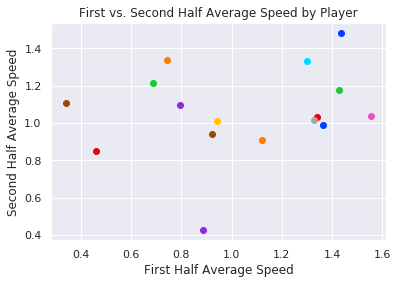

In [95]:
for player in np.arange(1,17):
    gpsx = gps[gps.PlayerID == player]
    grouped = gpsx.groupby('Half')
    series = grouped['Speed'].mean()
    print(player, series[1]-series[2])
    plt.plot(series[1],series[2],'o')
plt.xlabel('First Half Average Speed')
plt.ylabel('Second Half Average Speed')
plt.title('First vs. Second Half Average Speed by Player')
plt.show()

A comparison of the average speed of each player in the first and second halves of games is shown above.